In [1]:
from google.cloud import bigquery
import os
import pandas as pd

GCP_PROJECT = 'opensource-observer'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../../../oso_gcp_credentials.json'
client = bigquery.Client(GCP_PROJECT)

In [66]:
query = """
with 
-- Step 1: Relevant Projects with Metrics
relevant_projects as (
    select distinct
        project_id,
        project_name
    from `oso_production.onchain_metrics_by_project_v1`
    where
        event_source in ('OPTIMISM', 'BASE', 'MODE', 'ZORA')
        and transaction_count_6_months > 1000
        and project_id in (
            select project_id from `oso_production.projects_by_collection_v1`
            where collection_name = 'op-retrofunding-4'
        )
),

-- Step 2: Relevant Repositories
relevant_repos as (
    select
        r.artifact_id,
        r.project_id,
        rp.project_name,
        r.language
    from `oso_production.repositories_v0` r
    join relevant_projects rp on r.project_id = rp.project_id
    where 
        r.language in ('TypeScript', 'Solidity', 'Rust')
),

-- Step 3: Core Developers
core_devs as (
    select
        e.from_artifact_id as developer_id,
        u.display_name as developer_name,
        e.to_artifact_id as repo_id
    from `oso_production.int_events__github` e
    join `oso_production.users_v1` u
    on e.from_artifact_id = u.user_id
    where e.to_artifact_id in (select artifact_id from relevant_repos)
        and e.event_type = 'COMMIT_CODE'
        and u.display_name not like '%[bot]%'
    group by 1,2,3
    having
        count(distinct date_trunc(time, month)) >= 3
        and sum(amount) >= 20
),

-- Step 4: Repositories with Releases
repos_with_releases as (
    select distinct to_artifact_id
    from `oso_production.int_events__github`
    where event_type = 'RELEASE_PUBLISHED'
),

-- Step 5: Developer Interactions with Dev Tools
dev_interactions as (
    select
        rr.project_id as `Project ID`,
        rr.project_name as `Project Name`,
        target_p.project_id as `Dev Tool ID`,
        target_p.project_name as `Dev Tool Name`,
        cd.developer_id as `Developer ID`,
        count(distinct cd.developer_id) as `Num Project Devs Engaging with Dev Tool`
    from core_devs cd
    join relevant_repos rr on cd.repo_id = rr.artifact_id
    join `oso_production.int_events__github` e on cd.developer_id = e.from_artifact_id
    left join `oso_production.repositories_v0` target_rm on e.to_artifact_id = target_rm.artifact_id
    left join `oso_production.projects_v1` target_p on target_rm.project_id = target_p.project_id
    where e.to_artifact_id not in (select artifact_id from relevant_repos)
        and e.to_artifact_id in (select to_artifact_id from repos_with_releases)
        and e.time >= '2023-01-01'
        and target_p.project_id in (
            select project_id from `oso_production.projects_by_collection_v1`
            where collection_name = 'op-rpgf3'
        )
    group by 1,2,3,4,5
),

-- Step 6: Dependency Relationships
dependency_relationships as (
    select
        sboms.from_project_id as `Project ID`,
        onchain_builders.project_name as `Project Name`,
        dev_tools.project_id as `Dev Tool ID`,
        dev_tools.project_name as `Dev Tool Name`,
        'Dependency' as `Relationship Type`
    from `oso_production.sboms_v0` as sboms
    join `oso_production.projects_by_collection_v1` as onchain_builders
        on sboms.from_project_id = onchain_builders.project_id
    join `oso_production.package_owners_v0` as pkgs
        on sboms.to_package_artifact_name = pkgs.package_artifact_name
        and sboms.to_package_artifact_source = pkgs.package_artifact_source
    join `oso_production.projects_v1` as dev_tools
        on pkgs.package_owner_project_id = dev_tools.project_id
    where
        onchain_builders.collection_name = 'op-retrofunding-4'
        and dev_tools.project_id in (
            select project_id from `oso_production.projects_by_collection_v1`
            where collection_name = 'op-rpgf3'
        )
    group by 1,2,3,4
),

-- Step 7: Smart Contract Developers for Each Project
smart_contract_devs as (
    select distinct
        cd.developer_id as `Smart Contract Developer ID`,
        rr.project_id as `Project ID`
    from core_devs cd
    join relevant_repos rr on cd.repo_id = rr.artifact_id
    where rr.language = 'Solidity'
),

-- Step 8: Combined Relationships
combined_relationships as (
    select
        coalesce(e.`Project ID`, d.`Project ID`) as `Project ID`,
        coalesce(e.`Project Name`, d.`Project Name`) as `Project Name`,
        coalesce(e.`Dev Tool ID`, d.`Dev Tool ID`) as `Dev Tool ID`,
        coalesce(e.`Dev Tool Name`, d.`Dev Tool Name`) as `Dev Tool Name`,
        case
            when e.`Project ID` is not null and d.`Project ID` is not null then 'Both'
            when e.`Project ID` is not null then 'Engagement'
            when d.`Project ID` is not null then 'Dependency'
        end as `Relationship Type`
    from dev_interactions e
    full outer join dependency_relationships d
    on e.`Project ID` = d.`Project ID`
    and e.`Dev Tool ID` = d.`Dev Tool ID`
)

-- Final Output: Unified Table
select
    cr.`Project ID`,
    cr.`Project Name`,
    cr.`Dev Tool ID`,
    cr.`Dev Tool Name`,
    cr.`Relationship Type`,
    count(distinct di.`Developer ID`) as `Num Project Devs Engaging with Dev Tool`,
    count(distinct case when scd.`Project ID` = cr.`Project ID` then scd.`Smart Contract Developer ID` end) as `Num Smart Contract Devs Engaging with Dev Tool`,    
    sum(om.transaction_count_6_months) as `Project Total Txns`,
    sum(om.gas_fees_sum_6_months) as `Project Total Gas Fees`
from combined_relationships cr
left join `oso_production.onchain_metrics_by_project_v1` om on cr.`Project ID` = om.project_id
left join dev_interactions di on cr.`Project ID` = di.`Project ID` and cr.`Dev Tool ID` = di.`Dev Tool ID`
left join smart_contract_devs scd on cr.`Project ID` = scd.`Project ID`
group by 1,2,3,4,5
order by `Project ID`;
"""

result = client.query(query)
df = result.to_dataframe()
df.tail()

,Project ID,Project Name,Dev Tool ID,Dev Tool Name,Relationship Type,Num Project Devs Engaging with Dev Tool,Num Smart Contract Devs Engaging with Dev Tool,Project Total Txns,Project Total Gas Fees
2036,zuKa56R3a-6e4jZZUfd7UOWS66f0hkwUMt8uFboQArk=,biconomy,D3mUC1uetKFVx1xSk39LA6L7IG93NmwmCIqjArMu8i4=,ethers-io,Both,1,3,45795.0,0.221415
2037,zuKa56R3a-6e4jZZUfd7UOWS66f0hkwUMt8uFboQArk=,biconomy,Pv9DcQi2GVUwbkEZPSnblqG96Ij1wGqJaeR_2OTedCk=,lighthouse-sigp,Engagement,1,3,45795.0,0.221415
2038,zuKa56R3a-6e4jZZUfd7UOWS66f0hkwUMt8uFboQArk=,biconomy,Skg2WIacZgsQJx8bP11NeCHF6mkHjHZ-VCmKmi97u3U=,solidity-ethereum,Engagement,1,3,45795.0,0.221415
2039,zuKa56R3a-6e4jZZUfd7UOWS66f0hkwUMt8uFboQArk=,biconomy,AMRUj6HUvwYnxDOM8OlY2YoA4f33M2X7NODmHamC_XI=,hardhat-tracer-zemse,Engagement,1,3,45795.0,0.221415
2040,zuKa56R3a-6e4jZZUfd7UOWS66f0hkwUMt8uFboQArk=,biconomy,KHHcusE_j4--ADJVcKQcBG1M5M6x_DU8H_RW-fmmhCs=,wighawag,Dependency,0,3,45795.0,0.221415


In [67]:
df.to_csv('data/prelim_weighted_graph.csv')

In [20]:
import networkx as nx
import json

In [21]:
G = nx.DiGraph()

In [ ]:
df_utility.groupby(['Project ID', 'Dependency'])

In [41]:
# First add package dependencies

for _, row in df_adoption.iterrows():
    p_id = row['Project ID']
    d_id = row['Dependency ID']
    
    # Add project node if not already in the graph
    if p_id not in G.nodes():
        G.add_node(
            p_id,
            project_type='Onchain Builder',
            project_name=row['Project Name'],
            project_transactions=row['Project Total Txns'],
            project_gas_fees=row['Project Total Gas Fees']
        )
    
    # Add dependency node if not already in the graph
    if d_id not in G.nodes():
        G.add_node(
            d_id,
            project_type='Dev Package',
            project_name=row['Dependency']
        )
    
    # Add edge only if it doesn't already exist
    if not G.has_edge(p_id, d_id):
        dev_links = df_utility[(df_utility['Project ID'] == p_id) & (df_utility['Dependency ID'] == d_id)]['Developer ID'].unique()
        G.add_edge(
            p_id, d_id,
            edge_type='Package Dependency',
            dev_links=len(dev_links),
            solidity_dev_links=len([x for x in dev_links if x in df_devs['Developer ID']])
        )

# Then add other projects of interest to onchain builders

for _, row in df_utility.iterrows():
    p_id = row['Project ID']
    d_id = row['Dependency ID']
    
    # Add dependency node if not already in the graph
    if d_id not in G.nodes():
        G.add_node(
            d_id,
            project_type='OS Tool',
            project_name=row['Dependency Name']
        )
    
    # Add edge only if it doesn't already exist
    if not G.has_edge(p_id, d_id):
        dev_links = df_utility[(df_utility['Project ID'] == p_id) & (df_utility['Dependency ID'] == d_id)]['Developer ID'].unique()
        G.add_edge(
            p_id, d_id,
            edge_type='Important Repo',
            dev_links=len(dev_links),
            solidity_dev_links=len([x for x in dev_links if x in df_devs['Developer ID']])
        )

In [42]:
df_adoption.tail()

,Project ID,Dependency ID,Project Name,Dependency,Project Total Txns,Project Total Gas Fees
1157,kVeul81pcomlG3BHGnuKWAECfpCk_XLxN_AUgTWbkWo=,D3mUC1uetKFVx1xSk39LA6L7IG93NmwmCIqjArMu8i4=,sushi,ethers-io,1.018108e+09,5076.661306
1158,I1ULrUY9t789vj4akEP3lLgB9hmC1Unfg7875NEdWL0=,D3mUC1uetKFVx1xSk39LA6L7IG93NmwmCIqjArMu8i4=,lifinance,ethers-io,1.135957e+09,3335.429666
1159,sbnlvN2OV8y140ijKiAr12nnhEkcKAYZyaxtOZOteqs=,D3mUC1uetKFVx1xSk39LA6L7IG93NmwmCIqjArMu8i4=,across,ethers-io,1.200631e+09,11163.584370
1160,UF36qYsUzfwX6GDNuWgpDXrqsmrLcK4Rw5D4hZY5Pxc=,D3mUC1uetKFVx1xSk39LA6L7IG93NmwmCIqjArMu8i4=,layer-zero,ethers-io,3.860114e+09,5996.633767
1161,PZA75rAKiN4P9poFNpkZYK-yrF1r3WgpEHmbvwPjbXk=,D3mUC1uetKFVx1xSk39LA6L7IG93NmwmCIqjArMu8i4=,zora,ethers-io,8.572884e+09,17305.571616


In [44]:
graph_json = nx.node_link_data(G)
with open('data/prelim_weighted_graph.json', 'w') as f:
    json.dump(graph_json, f, indent=2)

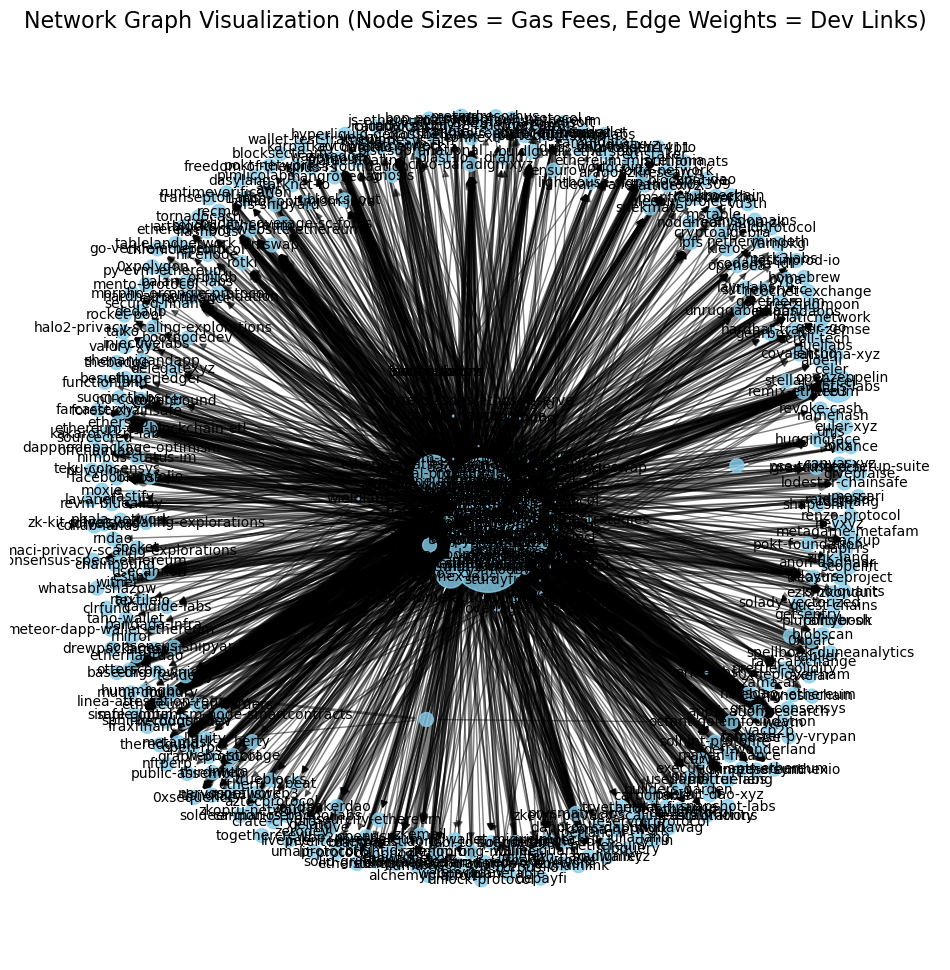

In [46]:
import matplotlib.pyplot as plt

# Extract labels for nodes using the project_name attribute
labels = {node: data['project_name'] for node, data in G.nodes(data=True) if 'project_name' in data}

# Extract node sizes based on gas fees (use a default size for nodes without gas fees)
node_sizes = [
    data.get('project_gas_fees', 10) * 10  # Scale gas fees for better visualization
    for _, data in G.nodes(data=True)
]

# Extract edge weights based on dev_links (use a default weight for edges without dev_links)
edge_weights = [
    data.get('dev_links', 1)  # Use 1 as a default weight
    for _, _, data in G.edges(data=True)
]

# Draw the graph
plt.figure(figsize=(12, 12))  # Adjust figure size as needed
pos = nx.spring_layout(G)  # Use a spring layout for better aesthetics

# Draw nodes and edges
nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,  # Node sizes proportional to gas fees
    node_color='skyblue', 
    alpha=0.8
)
nx.draw_networkx_edges(
    G, pos,
    width=edge_weights,  # Edge widths proportional to dev_links
    alpha=0.5
)

# Add labels to the nodes using project_name
nx.draw_networkx_labels(G, pos, labels, font_size=10, font_color='black')

# Add a title to the plot
plt.title("Network Graph Visualization (Node Sizes = Gas Fees, Edge Weights = Dev Links)", fontsize=16)
plt.axis('off')  # Turn off the axes
plt.show()

In [3]:
#df.to_csv('data/prelim_weighted_graph.csv')